In [2]:
import numpy as np
import random
from math import pi, sqrt
import sys
import os.path
import matplotlib.pyplot as plt
import time

In [16]:
# generates single particle states
def wf_gen(N,N_pt,BC,t):
    hop= np.diag(np.ones(N-1)+0j,1)
    hop[N-1,0]= BC
    H_t= -t*(hop+ np.matrix(hop).H)/2
    energies, evecs= np.linalg.eigh(H_t)
    exact_gs_energy=  np.sum(energies[:N_pt])
    print('exact gs energy=', exact_gs_energy)
#     plt.figure()
#     plt.plot(energies,'o')
#     plt.show()
    return evecs[:,:N_pt]

# VMC function 
def VMC_main(numconfig,t,V1,wf_1,N,N_pt,BC,n_occ1,n_pos1):

    move_attempted=0.0
    move_accepted=0.0

    wf_inv=np.linalg.inv(wf_1)
    
    count=0 # counter for energy
    howoften=10 # calculate energy every 10 steps
    min_step=500
    ratio_0=1.0+0.0j    
    
    ratio=np.zeros((numconfig,),dtype=np.complex64)
    E_t=np.zeros(int(numconfig/howoften),dtype=np.complex64) # total energy
    
    for step in range(numconfig+min_step):
        for moved_elec in range(N_pt):
            move_attempted=move_attempted+1

            # random walk of one step left or right
            att_num=random.randint(1,2)
            if att_num==1:
                stepx=1
            else:
                stepx=0

            ptcls_x= np.mod( n_pos1[moved_elec]+stepx, N) # new configuration

            if n_occ1[ptcls_x]==1:
                continue

            pt_wf_1=np.transpose(V1[ptcls_x,:])

            rel=np.dot(wf_inv[moved_elec,:],pt_wf_1)

            alpha=min(1, np.abs(rel)**2)
            
            random_num=random.random()

            if random_num <= alpha:
                # SMW method to compute inverse of slater det
                u_1=pt_wf_1 - wf_1[:,moved_elec]
                v=np.zeros((N_pt,1))
                v[moved_elec]=1
                wf_inv=wf_inv - np.dot(np.dot(np.dot(wf_inv,u_1),v.T),wf_inv) \
                                 /(1+np.dot(v.T,np.dot(wf_inv,u_1))) 
                wf_1[:,moved_elec]=pt_wf_1
#                 wf_inv=np.linalg.inv(wf_1)

                move_accepted=move_accepted+1
                n_occ1[n_pos1[moved_elec]]= n_occ1[n_pos1[moved_elec]]-1
                n_pos1[moved_elec]=ptcls_x
                n_occ1[ptcls_x]= n_occ1[ptcls_x]+1
                if step> min_step:
                    ratio_0=ratio_0*rel

# ##############################################################
        assert n_occ1.sum()==N_pt, "total particle number changes!!"      
            
        if step> (min_step-1):

            if ((step-min_step+1)%howoften)==0:
                E_t[count] =energy_calc(t,V1,N,N_pt,BC,wf_inv,n_occ1,n_pos1)
                count+=1
        
        if (step%500) ==0:
            wf_inv=np.linalg.inv(wf_1)

    acc_ratio=move_accepted/move_attempted
    i_c=4
    print("<H> for iteration %d = " % (i_c), E_t[i_c])
    
    plt.figure()
    plt.plot(np.real(E_t),'o')
    plt.show()


    print("the acceptance rate=", acc_ratio)


# calculates energy 
def energy_calc(t,V1,N,N_pt,BC,wf_inv,n_occ1,n_pos1):
    
    E_t=0.0+0.0j
    
    for moved_elec in range(N_pt):
    #### t1 term
        ptcls_x= np.mod( (n_pos1[moved_elec])+1, N)
        pt_wf_1=np.transpose(V1[ptcls_x,:])
        Ecalc=np.dot(wf_inv[moved_elec,:],pt_wf_1)
        if n_pos1[moved_elec]== N-1:
            E_t += (BC)*Ecalc
        else:
            E_t += Ecalc

        ptcls_x= np.mod( (n_pos1[moved_elec])-1, N)
        pt_wf_1=np.transpose(V1[ptcls_x,:])
        Ecalc=np.dot(wf_inv[moved_elec,:],pt_wf_1)
        if n_pos1[moved_elec]== 0:
            E_t += np.conj(BC)*Ecalc
        else:
            E_t += Ecalc

    return -t*E_t/2

# initialize wavefunction 
def initialize_wf(N,N_pt):
    n_occ=np.zeros((N,))        
    n_pos=random.sample(range(N),N_pt)
    n_occ[n_pos]=np.ones((N_pt,))        
    
    return n_occ

exact gs energy= -31.836225209097627
<H> for iteration 4 =  (-31.836226+4.4133034e-16j)


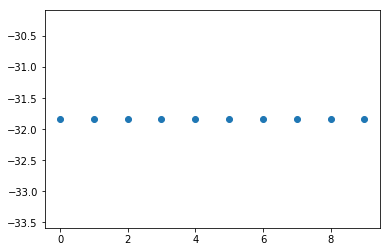

the acceptance rate= 0.2507333333333333
VMC finished, elapsed time = 1.766256332397461 sec


In [18]:

scratch="output_files/"

# system size
N=40
# number of electrons
N_pt=int(N/2)


t=1.0 # hopping amplitude
BC=np.exp(1j*pi) # boundary condition on a chain, you can put BC=0 for open chain
# BC=1 periodic boundary condition and BC=-1 is anti-periodic
# do not put BC=1 since the gs is not unique in that case
numconfig=100

t_timer=time.time()
random.seed(time.time())
# #################################################################
# ##### Execution Part
# #################################################################

# ##### initialization
n_occ1=initialize_wf(N,N_pt) # occupation numbers 
n_pos1,=n_occ1.nonzero() # position of the particles
# #################################################################
# ##### Slater determinant
# #################################################################
V1=wf_gen(N,N_pt,BC,t) # occupied single particle states
wf_ref=np.transpose(V1[n_pos1,:]) # initial slater determinant


##### make sure the initial config of slater determinant is not singular
counter=0
epsilon= 1e-8
while np.linalg.cond(wf_ref) > 1/epsilon:
    counter+=1
    assert counter<=40, "wave function cannot be constructed!"
    n_occ1=initialize_wf(N,N_pt) 
    n_pos1,=n_occ1.nonzero() 
    wf_ref=np.transpose(V1[n_pos1,:]) # initial slater determinant



VMC_main(numconfig,t,V1,wf_ref,N,N_pt,BC,n_occ1,n_pos1)

elapsed = time.time() - t_timer
print("VMC finished, elapsed time =", elapsed, "sec")

